In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook

In [3]:
from torch import Tensor
import torch
import ipywidgets
import math
import matplotlib as mplot
import seaborn as sns
import time
import tqdm

#### Gradient Descent example 1: 
- Estimate a known polynomial of degree 2 (a, b, c ar eknown and inout by user)
    - f(x) = a*x^2 + bx + c

In [4]:
num_param_selector = ipywidgets.IntSlider(min=1, max=10)

In [5]:
num_param_selector

IntSlider(value=1, max=10, min=1)

In [6]:
num_params = num_param_selector.value

rng = torch.Generator()
rng.manual_seed(980856756)
func_params = torch.randn(num_params, generator=rng)
func_params

tensor([-1.0473, -0.9675, -0.3490, -0.1852,  0.4688])

In [7]:
def target_func(x,f_params=func_params):
    exp = torch.arange(start=f_params.size()[0]-1, end=-1, step=-1)
    x = x.unsqueeze(1)    
    return torch.sum(torch.pow(x, exp)*f_params, dim=1)

<IPython.core.display.Javascript object>


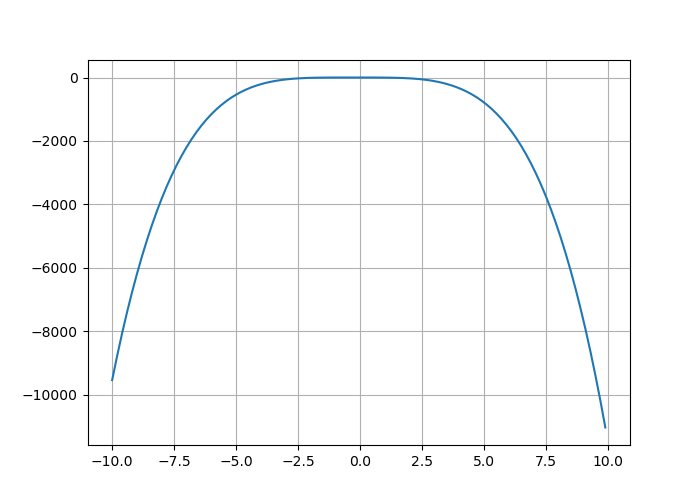

In [8]:
fig, axes = mplot.pyplot.subplots(figsize=(7, 5), nrows=1, ncols=1)

x = Tensor([i/10 for i in range(-100, 100, 1)])
y = target_func(x)
y_lims = [y.min().item(), y.max().item()]
axes.plot(x, y)
mplot.pyplot.grid(b=True)

mplot.pyplot.show()

In [9]:
def estimate(e_params, x):
    exp = torch.arange(start=e_params.size()[0]-1, end=-1, step=-1)
    xp = torch.arange(start=e_params.size()[0]-1, end=-1, step=-1)
    x = x.unsqueeze(1)    
    return torch.sum(torch.pow(x, exp)*e_params, dim=1)
    

#### gradient descent method

1. select random params e of n dimensions
2. generate an estimate(e) as $\sum_{i=0}^{n} x^{i}*e(i)$
3. calculate error(e) = err(actual - estimate) (l1 or l2 loss)
4. calculate step = d error(e) wrt e
5. e = e - learning rate *step

In [16]:
degrees = 4
rng = torch.Generator()
rng.manual_seed(9898797)
est_params = torch.randn(degrees+1, generator=rng)*10
est_params = est_params.requires_grad_()
est_params

tensor([ -7.3338,  20.6363,   0.4278, -12.6650,   5.6964], requires_grad=True)

In [17]:
err_func = torch.nn.MSELoss()
learning_rate = [0.1, 0.1, 0.1, 0.01, 0.001, 0.001, 0.0001, 0.00001, 0.000001][min(degrees, 8)]
learning_rate

0.001

In [18]:
valid_x = Tensor([i/10 for i in range(-25, 25, 1)])
valid_y = target_func(valid_x)

<IPython.core.display.Javascript object>


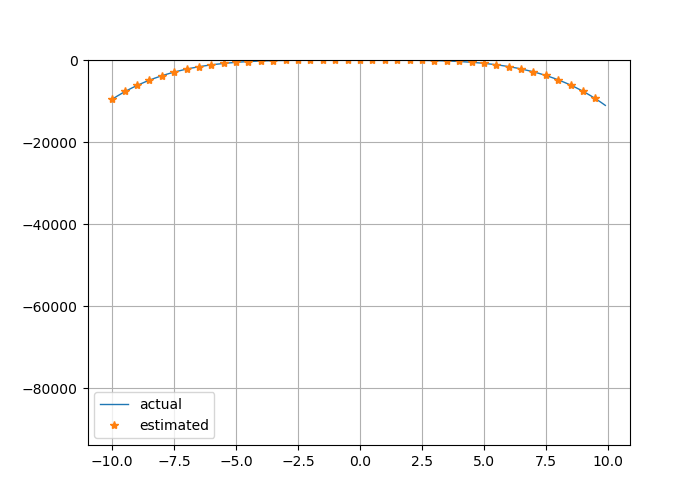

In [19]:
fig, axes = mplot.pyplot.subplots(figsize=(7, 5), nrows=1, ncols=1)

x = Tensor([i/10 for i in range(-100, 100, 1)])
y = target_func(x)

e_y = estimate(est_params.data, x[::5])

axes.set_ylim(min(y_lims[0], e_y.min().item()), max(y_lims[1], e_y.max().item()) )

axes.plot(x, y, label='actual', linewidth=1)
plot1,  = axes.plot(x[::5], e_y, label='estimated', linestyle='', marker='*')
mplot.pyplot.grid(b=True)
mplot.pyplot.legend(['actual', 'estimated'])
mplot.pyplot.show()

In [20]:
step_sz = 1 + max(degrees - 2, 0)*10
next_update = step_sz
N = 200 + max(degrees - 2, 0)*5000
pbar = tqdm.notebook.tqdm(total=N, leave=False)

for i in range(0, N):
    est_y = estimate(est_params, valid_x)
    err = err_func(est_y, valid_y)
    err.backward()
    est_params.data = est_params.data - learning_rate*est_params.grad.data
    est_params.grad = None    
    
    pbar.update(1)
    
    if i >= next_update:
        e_y = estimate(est_params.data, x[::5])
        plot1.set_ydata(e_y)    
        fig.canvas.draw()
        fig.canvas.flush_events()
        time.sleep(0.05)
        
        next_update += step_sz
    
pbar.close()    
print(est_params.data, err.item())

  0%|          | 0/10200 [00:00<?, ?it/s]

tensor([-1.0296, -0.9577, -0.4572, -0.2241,  0.5737]) 0.004042000509798527


In [22]:
num_params

5

<IPython.core.display.Javascript object>


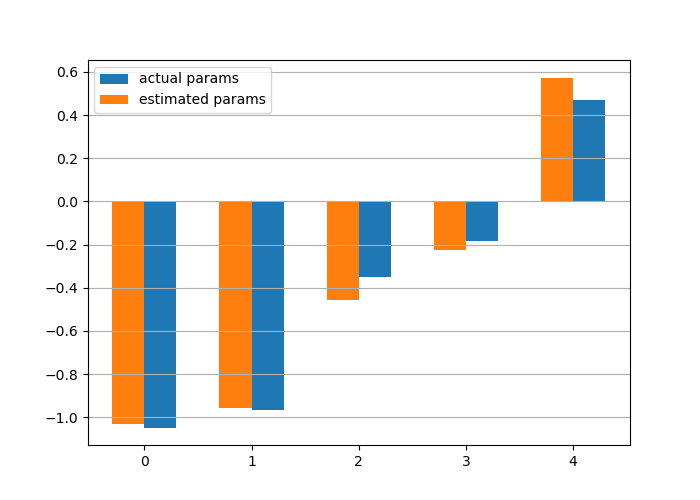

In [23]:
fig, axes = mplot.pyplot.subplots(figsize=(7, 5), nrows=1, ncols=1)

width = -0.3

axes.bar([i - width/2 for i in range(0, num_params, 1)], func_params.data, width=width)
if est_params.size()[0] >= num_params:
    axes.bar([i + width/2 for i in range(0, num_params, 1)], est_params.data[-num_params:], width=width)
else:
    est_p = torch.concat((torch.zeros(num_params - est_params.size()[0]), est_params.data))
    axes.bar([i + width/2 for i in range(0, num_params, 1)], est_p, width=width)
mplot.pyplot.grid(b=True, axis='y')
mplot.pyplot.legend(['actual params', 'estimated params'])
mplot.pyplot.show()